In [1]:
# Import packages

import pandas as pd
import numpy as np
import math
from datetime import datetime
from xgboost import XGBRegressor
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read and preview data

df = pd.read_csv('/Users/vedantsinghania/code/export_yardi_jourentline.csv', lineterminator='\n')
df.head()

,GLCODE,GLNAME,PROPERTY,PROPERTYNAME,UNIT,BUILDING,SPECIALCIRCUMSTANCE,USAGEAMOUNT,USAGETYPE,DATE,PERIOD,DESCRIPTION,CONTROL,REFERENCE,AMOUNT,DEBITCREDIT,BALANCE,REMARKS
0,1110-0000,Cash,ap-mc11,4203 11TH LLC,42031,,,,,09/09/2020,12/01/2020,Webster S8 (t0034597),K-396581,165,8500.0,Credit,1813181.59,First buyout check
1,1110-0000,Cash,ap-mc11,4203 11TH LLC,42032,,,,,09/29/2020,12/01/2020,Webster (t0034598),K-405215,173,2500.0,Credit,1810681.59,
2,1110-0000,Cash,ap-mc11,4203 11TH LLC,42031,,,,,10/27/2020,12/01/2020,Webster S8 (t0034597),K-417819,183,9100.0,Credit,1801581.59,
3,1110-0000,Cash,ap-mc11,4203 11TH LLC,42052,,,,,10/29/2020,12/01/2020,Jones (t0034602),K-420897,187,3500.0,Credit,1798081.59,First Buyout Check
4,1110-0000,Cash,ap-mc11,4203 11TH LLC,42053,,,,,11/02/2020,12/01/2020,Dow (t0034603),K-421957,190,3500.0,Credit,1794581.59,First Buyout Check


In [3]:
# Reformat columns

df.columns = df.columns.map(lambda a: a.strip())

df['DATE'] = df['DATE'].map(lambda d: datetime.strptime(d, ' %m/%d/%Y'))
df['PERIOD'] = df['PERIOD'].map(lambda p: datetime.strptime(p, ' %m/%d/%Y'))

df['DATEDAY'] = df['DATE'].map(lambda d: int(d.day))
df['DATEMO'] = df['DATE'].map(lambda d: int(d.month))
df['DATEYR'] = df['DATE'].map(lambda d: int(d.year))

df['PERIODDAY'] = df['PERIOD'].map(lambda d: int(d.day))
df['PERIODMO'] = df['PERIOD'].map(lambda d: int(d.month))
df['PERIODYR'] = df['DATE'].map(lambda d: int(d.year))

df = df.drop(columns=['DATE', 'PERIOD'], axis=1)

df['AMOUNT'] = df['AMOUNT'].map(lambda a: math.ceil(a))

In [4]:
# Define X and y

X = df.copy()
X = X.drop(['AMOUNT'], axis=1)

y = df['AMOUNT'].copy()

In [5]:
# Drop unneeded columns

X = X.drop(columns=['BUILDING', 'SPECIALCIRCUMSTANCE', 'USAGEAMOUNT', 'USAGETYPE', 'BALANCE', 'CONTROL', 'PERIODYR', 'DATEYR'])
print (X.columns)

Index(['GLCODE', 'GLNAME', 'PROPERTY', 'PROPERTYNAME', 'UNIT', 'DESCRIPTION',
       'REFERENCE', 'DEBITCREDIT', 'REMARKS', 'DATEDAY', 'DATEMO', 'PERIODDAY',
       'PERIODMO'],
      dtype='object')


In [6]:
# Find categorical columns
cat_cols = [col for col in X.columns if X[col].dtype == 'object']

In [7]:
# Split data into training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [8]:
# Label encode data

label_X_train = X_train.copy()
label_X_test = X_test.copy()
le = LabelEncoder()

for col in cat_cols:
    le.fit(label_X_train[col])

    label_X_test[col] = label_X_test[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<unknown>')

    label_X_train[col] = le.transform(label_X_train[col])
    label_X_test[col] = le.transform(label_X_test[col])

X_train = label_X_train.copy()
X_test = label_X_test.copy()

In [9]:
# Percent distribution function

def categorize_percents(p):
    if p >= 0 and p < 5:
        return 5
    elif p >= 5 and p < 10:
        return 10
    elif p >= 10 and p < 20:
        return 20
    elif p >= 20 and p < 50:
        return 50
    elif p >= 50 and p < 100:
        return 100
    elif p >= 100 and p < 200:
        return 200
    elif p >= 200 and p < 500:
        return 500
    elif p >= 500 and p < 1000:
        return 1000
    elif p >= 1000:
        return 10000
    else:
        return 'unknown'

In [10]:
# Fit/predict model and print report
model = XGBRegressor(random_state=1, n_jobs=-1, learning_rate=0.22, n_estimators=10000, max_depth=7, objective='count:poisson', colsample_bytree=0.2)
model.fit(X_train, y_train, early_stopping_rounds=25, eval_set=[(X_test, y_test)], verbose=False)
training_preds = model.predict(X_train)
test_preds = pd.Series(model.predict(X_test))

print('Scores')
print('R\u00b2 (training):', r2_score(y_train, training_preds))
print('R\u00b2 (test):', r2_score(y_test, test_preds))
print('MAE (test):', mean_absolute_error(y_test, test_preds))
print('RMSE (test):', mean_squared_error(y_test, test_preds, squared=False))
print('')


percents_list = []

for i in range(0, len(y_test)):
    real = y_test[i]
    pred = test_preds[i]
    percent_of_real = (pred/real)*100
    percent_off = abs(100-percent_of_real)
    percents_list.append(round(percent_off, 2))

percents_df = pd.DataFrame(percents_list, columns=['percent_off'])
percents_df.head()

percents_df['Category (%)'] = percents_df.apply(lambda p: categorize_percents(p['percent_off']), axis=1)
percent_range_df = percents_df.groupby('Category (%)').size().reset_index(name='Count')
percent_range_df['Percent of Total (%)'] = percent_range_df['Count']/len(percents_df.index)*100

print('% Off Distribution')
print(percent_range_df)
print('')
print('Preds')
print('Avg:', test_preds.mean())
print('Min:', test_preds.min())
print('Max:', test_preds.max())
print('')
print('Actuals')
print('Avg:', y_test.mean())
print('Min:', y_test.min())
print('Max:', y_test.max())
print('')

Scores
R² (training): 0.9821118335775684
R² (test): 0.6619346763391929
MAE (test): 1385.5034576840526
RMSE (test): 26817.116417637102

% Off Distribution
   Category (%)  Count  Percent of Total (%)
0             5    471              3.240454
1            10    424              2.917097
2            20    949              6.529068
3            50   2716             18.685931
4           100   2619             18.018576
5           200   1270              8.737530
6           500   1769             12.170623
7          1000   1285              8.840729
8         10000   3032             20.859993

Preds
Avg: 1549.6246337890625
Min: 1.237297773361206
Max: 2523192.25

Actuals
Avg: 2118.9810113519093
Min: 1
Max: 3840000



<AxesSubplot:title={'center':'Predictions vs. Actual Values'}>

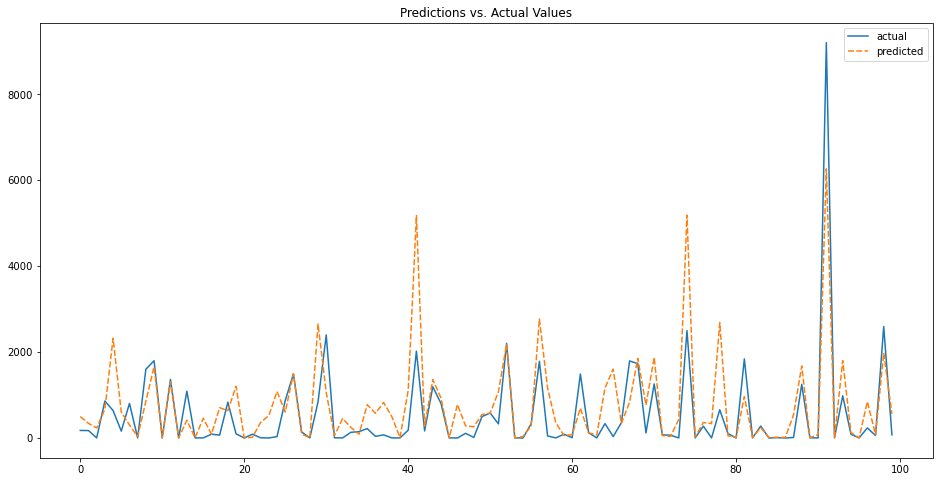

In [11]:
    # Plot predictions against actual values
    
    comparison = pd.concat([y_test, test_preds], axis=1)
    comparison.columns = ['actual', 'predicted']
    plt.figure(figsize=(16,8))
    plt.title('Predictions vs. Actual Values')
    
    sns.lineplot(data=comparison[0:100])

<AxesSubplot:xlabel='DATEYR', ylabel='AMOUNT'>

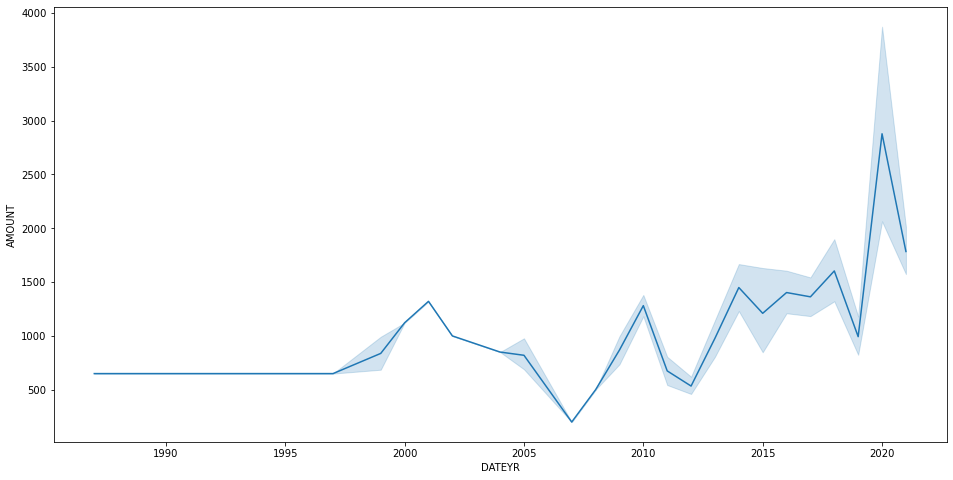

In [12]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=df, x='DATEYR', y='AMOUNT')